In [2]:
import gymnasium as gym
import customENV.customENVInit
from modelCall.RASZeroSumCall import Actor
from modelCall.RACall import Actor as RAActor
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.patches import Circle

In [3]:
# Create a Combine-v1 environment
env = gym.make("Combine-v1")

# Reset the environment
obs, info = env.reset()

# Get the observation space
low = env.observation_space.low
high = env.observation_space.high

# Set the discritization
disc = 500

# Create a list of 10 states per dimension between low and high
x = np.linspace(low[0], high[0], disc)
y = np.linspace(low[1], high[1], disc)

# Create a meshgrid over the states
X, Y = np.meshgrid(x, y)

# Create a grid of rewards size of X
rewards = np.zeros(X.shape)

# Create a grid of reach size of X
reach = np.zeros(X.shape)

# Create a grid of avoid size of X
avoid = np.zeros(X.shape)

# Iterate over the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        
        # Set the observation to the current state
        state = np.array([X[i, j], Y[i, j], 0, 0, 0])

        # Reset the environment
        env.reset(state_init=state)

        # Step the environment
        obs, reward, terminated, truncated, info = env.step([0, 0, 0])

        # Get the reward
        rewards[i, j] = reward

        # Get the reach
        reach[i, j] = info["reach"]

        # Get the avoid
        avoid[i, j] = info["avoid"]

/home/gechenev/Documents/GitHub/RASDemo/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment Combine-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(
/home/gechenev/Documents/GitHub/RASDemo/.venv/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


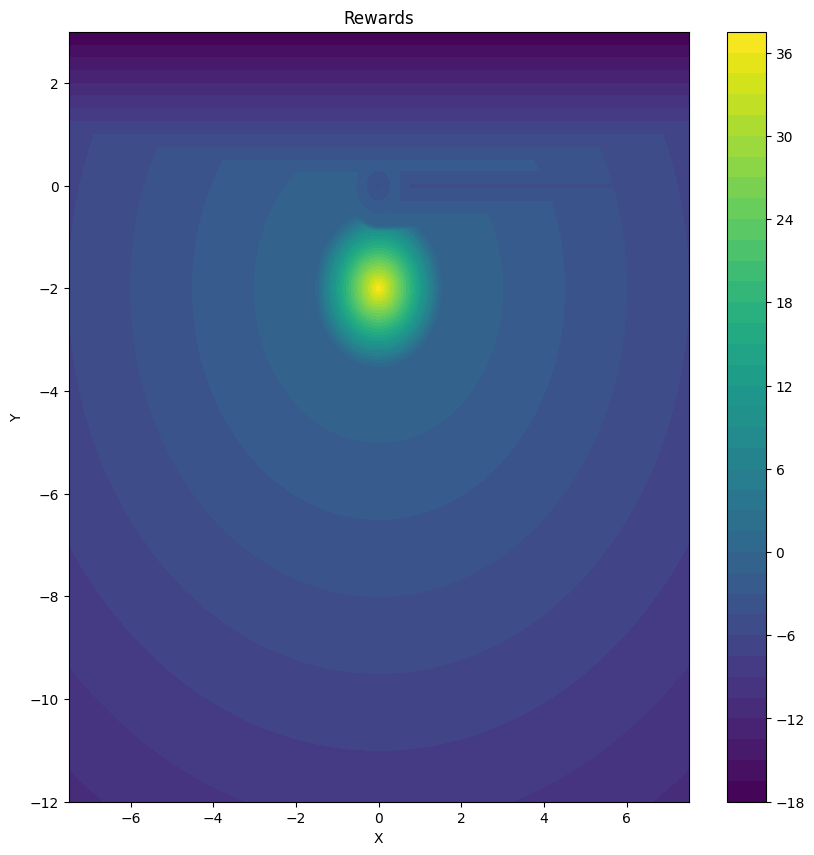

In [4]:
# Create a contour plot of the rewards
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, rewards, levels=50)
plt.colorbar()
plt.title("Rewards")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

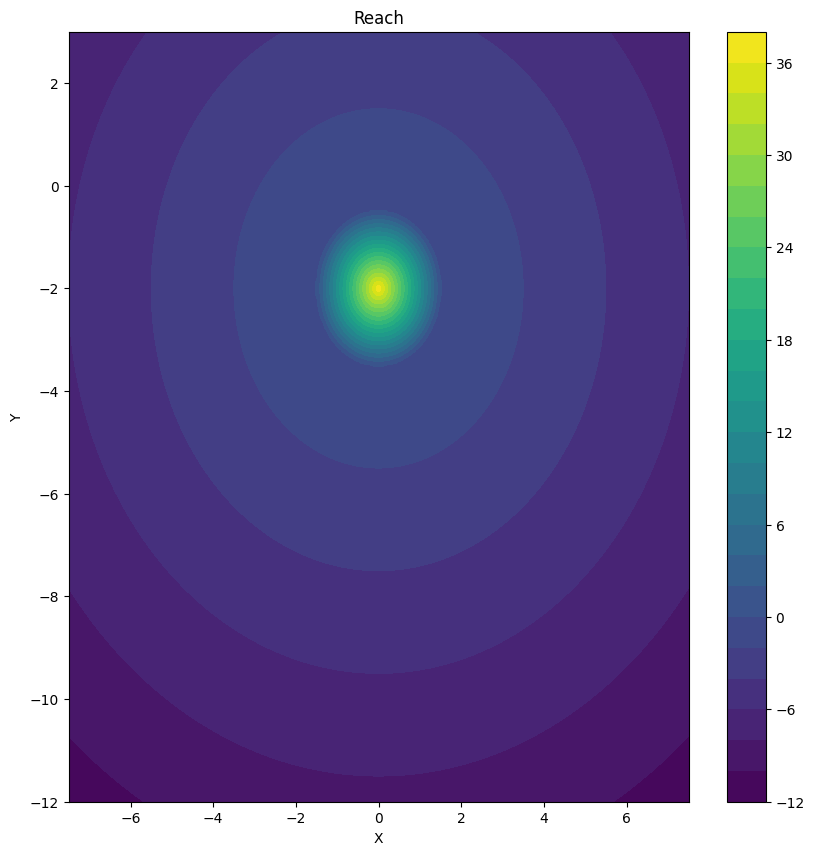

In [5]:
# Create a contour plot of the reach
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, reach, levels=30)
plt.colorbar()
plt.title("Reach")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

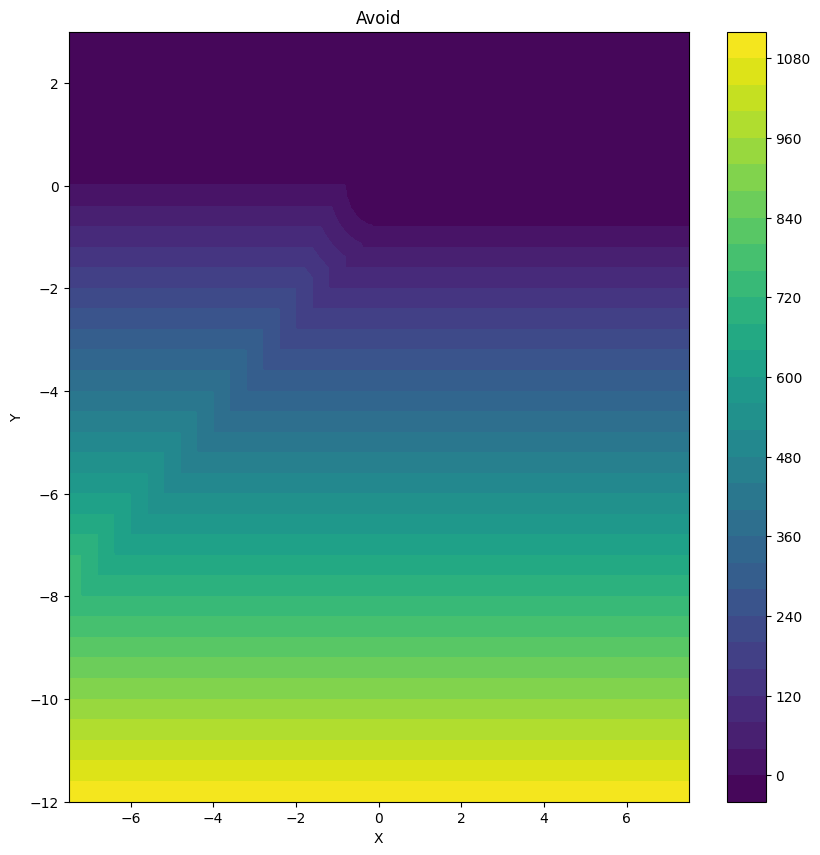

In [6]:
# Create a contour plot of the avoid
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, avoid, levels=30)
plt.colorbar()
plt.title("Avoid")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [7]:
# Print the maximum reward
print("Maximum reward:", np.max(rewards))

# Print the minimum reward
print("Minimum reward:", np.min(rewards))

Maximum reward: 37.04840289635973
Minimum reward: -18.0


In [8]:
# Test the center of the target

# Set x
x = 0

# Set y
y = -2

# Reset the environment to x=0, y=-2
env.reset(state_init = np.array([x, y, 0, 0, 0]))

# Step the environment with 0 action
obs, reward = env.step([0,0,0])[0:2]

# Print the reward
print("Reward at x=",x,", y=", y," ", reward)

Reward at x= 0 , y= -2   37.5


In [19]:
# Test just the stay action

# Check if we have gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the h policy
#h = torch.load("log/Combine-v2/ddpg/hPolicy.pth").to(device)
h = torch.load("log/Combine-v1/ddpg/hPolicy.pth").to(device)

# Create an actor
actor = Actor(device, h, h)

# Iterate over 1000 random states and check how many leave the target

# Set the number of random states
num_states = 1000

# Set the test length
test_length = 100

# Create a counter for the number of states that leave the target
count = 0

# Adjust the bounds for random state to 80% of the bounds
low = low * .8
high = high * .8

# Set a bool to track if we have entered the target
entered = False

# Iterate over the number of random states
for i in range(num_states):

    # Reset the entered bool
    entered = False

    # Create a random state
    state = np.random.uniform(low, high)

    # Reset the environment to the random state
    env.reset(state_init = state)

    # Check to see if the state is inside the lvl 0 set
    while not entered:

        # Get the action
        action, hReward = actor.getResult(torch.tensor([state], dtype=torch.float64))[0:2]

        # Process the action
        action = action.cpu().detach().numpy()

        # Take the action
        state, reward = env.step(action)[0:2]

        # Check if hReward is greater than 0
        if hReward >= 0 and reward > 0:
            entered = True
        else:
            # Roll a new state
            state = np.random.uniform(low, high)

            # Reset the environment to the random state
            env.reset(state_init = state)
            
    # Iterate over the test length
    for j in range(test_length):

        # Get the action
        action, hReward = actor.getResult(torch.tensor([state], dtype=torch.float64))[0:2]

        # Process the action
        action = action.cpu().detach().numpy()

        # Take the action
        state, reward = env.step(action)[0:2]

        # Check if we left the target
        if reward < 0:
            count += 1
            break

/tmp/ipykernel_820235/330907104.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  h = torch.load("log/Combine-v1/ddpg/hPolicy.pth").to(device)


In [20]:
# Print the number of states that leave the target
print("Number of states that leave the target:", count)

# Print the percentage of states that left the target
print("Percentage of states that left the target:", count / num_states * 100)

Number of states that leave the target: 1000
Percentage of states that left the target: 100.0


In [21]:
# Setup to test the neural networks

# Load the v policy
v = torch.load("log/Combine-v1/ddpg/vPolicy.pth").to(device)

# Create an actor
actor = Actor(device, h, v)

# Set h,v to evaluation
h.eval()
v.eval()

# Load the environment with a h policy
env = gym.make("Combine-v1", hPolicy=h)

/tmp/ipykernel_820235/919947642.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  v = torch.load("log/Combine-v1/ddpg/vPolicy.pth").to(device)


In [22]:
# Plot a trajectory from 4, -2, 0, 0, .6 for 1000 steps

# Set the state
state = env.reset(state_init = np.array([-3, -3, 90, .5, .6]))[0]

# Create a list of states
states = []

# Create a list of actions
actions = []

# Create a list of rewards
rewards = []

# Step the environment for 1000 steps
for i in range(500):
    
    # Get the action
    action = actor.getResult(torch.tensor([state], dtype=torch.float64))[0]

    # Process the action
    action = action.cpu().detach().numpy()

    # Take the action
    state, reward = env.step(action)[0:2]

    # Append the state
    states.append(state)

    # Append the action
    actions.append(action)

    # Append the reward
    rewards.append(reward)

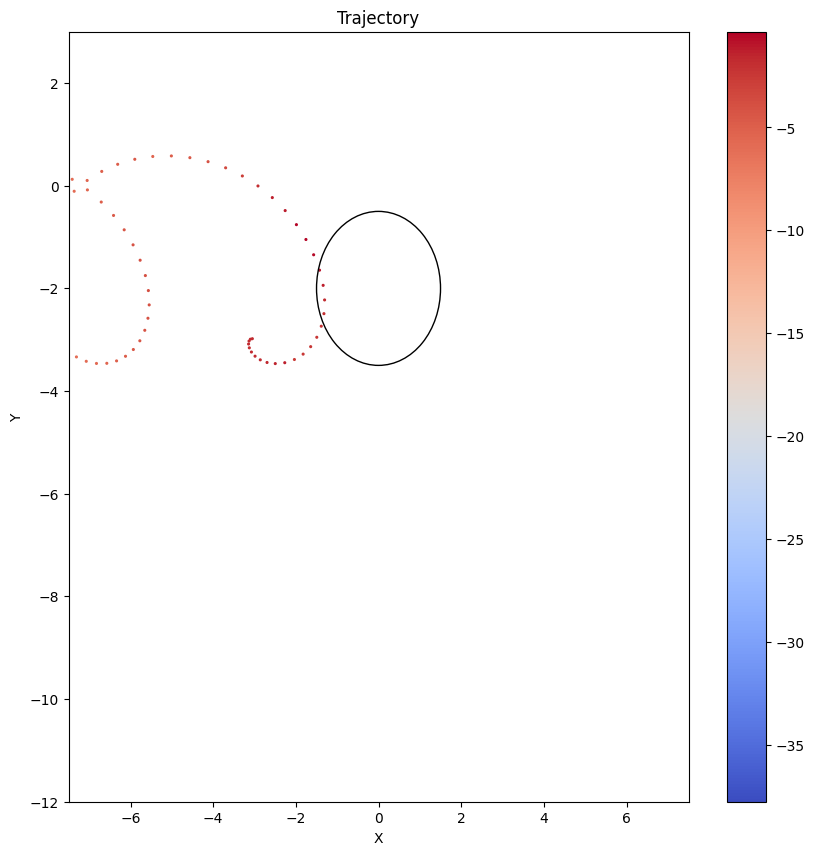

In [23]:
# Plot the trajectory
states = np.array(states)
plt.figure(figsize=(10, 10))
# Set the x limits to +/- 7.5
plt.xlim(-7.5, 7.5)
# Set the y limits to +3, -12
plt.ylim(-12, 3)
# plot trajectory with color based on the reward
plt.scatter(states[:, 0], states[:, 1], c=rewards, cmap="coolwarm", s=1.5)
# Draw a circle around the target
circle = Circle((0, -2), 1.5, edgecolor="black", facecolor="none")

# Add the circle to the plot
plt.gca().add_artist(circle)

plt.colorbar()
plt.title("Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [24]:
# Iterate over 1000 random states and check how many leave the target

# Set the number of random states
num_states = 1000

# Set the test length
test_length = 250

# Create a counter for the number of states that leave the target
count = 0

# Create a counter for the number of states that enter the target
enter = 0

# Set a bool to track if we have entered the target
entered = False

# Create an array to store the random states
states = np.zeros((num_states, 5))

# Iterate over the number of random states
for i in range(num_states):

    # Reset the entered bool
    entered = False

    # Create a random state
    state = np.random.uniform(low, high)

    # Reset the environment to the random state
    env.reset(state_init = state)

    # Set the good state to false
    goodState = False

    # Check to see if the state is inside the viability kernel
    while not goodState:

        # Get the action
        vReward = actor.getResult(torch.tensor([state], dtype=torch.float64))[2]

        # Check if hReward is greater than 0
        if vReward > 0:
            goodState = True
            
            # Store the state
            states[i] = state
        else:
            # Roll a new state
            state = np.random.uniform(low, high)

            # Reset the environment to the random state
            env.reset(state_init = state)

    # Iterate over the test length
    for j in range(test_length):

        # Get the action
        action, hReward = actor.getResult(torch.tensor([state], dtype=torch.float64))[0:2]

        # Process the action
        action = action.cpu().detach().numpy()

        # Take the action
        state, reward = env.step(action)[0:2]

        # Check if the state is inside the target
        if hReward > 0 and not entered:
            entered = True
            enter += 1

        # Check if we left the target
        elif reward < 0 and entered:
            count += 1
            break

In [25]:
# Print the number of states that entered the target
print("Number of states that entered the target:", enter)

# Print the percentage of states that entered the target
print("Percentage of states that entered the target:", enter / num_states * 100)

# Print the number of states that entered the target and stayed
print("Number of states that entered the target and stayed:", enter - count)

# Print the percentage of states that entered the target and stayed
print("Percentage of states that entered the target and stayed:", (enter - count) / enter * 100)

Number of states that entered the target: 332
Percentage of states that entered the target: 33.2
Number of states that entered the target and stayed: 0
Percentage of states that entered the target and stayed: 0.0


In [16]:
# REACH AVOID

# Load the RA policy
ra = torch.load("log/verify/raPolicy.pth").to(device)

# Set ra to evaluation
ra.eval()

# Create an actor
raActor = RAActor(device, ra)

/tmp/ipykernel_820235/355126253.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ra = torch.load("log/verify/raPolicy.pth").to(device)


FileNotFoundError: [Errno 2] No such file or directory: 'log/verify/raPolicy.pth'

In [ ]:
# Iterate over the same states and check how many leave the target

# Create a counter for the number of states that leave the target
count = 0

# Create a counter for the number of states that enter the target
enter = 0

# Set a bool to track if we have entered the target
entered = False

# Iterate over the random states
for state in states:

    # Reset the entered bool
    entered = False

    # Reset the environment to the random state
    env.reset(state_init = state)

    # Iterate over the test length
    for j in range(test_length):

        # Get the action
        action, raReward = raActor.getResult(torch.tensor([state], dtype=torch.float64))

        # Process the action
        action = action.cpu().detach().numpy()

        # Take the action
        state, reward = env.step(action)[0:2]

        # Check if the state is inside the target
        if reward > 0 and not entered:
            entered = True
            enter += 1

        # Check if we left the target
        elif reward < 0 and entered:
            count += 1
            break

In [ ]:
# Print the number of states that entered the target
print("Number of states that entered the target:", enter)

# Print the percentage of states that entered the target
print("Percentage of states that entered the target:", enter / num_states * 100)

# Print the number of states that entered the target and stayed
print("Number of states that entered the target and stayed:", enter - count)

# Print the percentage of states that entered the target and stayed
print("Percentage of states that entered the target and stayed:", (enter - count) / enter * 100)

In [ ]:
# Generate a trajectory with the RA policy

# Set the state
state = env.reset(state_init = np.array([-3, -3, 90, .5, .6]))[0]

# Create a list of states
states = []

# Create a list of actions
actions = []

# Create a list of rewards
rewards = []

# Step the environment for 1000 steps
for i in range(500):
    
    # Get the action
    action = raActor.getResult(torch.tensor([state], dtype=torch.float64))[0]

    # Process the action
    action = action.cpu().detach().numpy()

    # Take the action
    state, reward = env.step(action)[0:2]

    # Append the state
    states.append(state)

    # Append the action
    actions.append(action)

    # Append the reward
    rewards.append(reward)

In [ ]:
# Plot the trajectory
states = np.array(states)
plt.figure(figsize=(10, 10))
# Set the x limits to +/- 7.5
plt.xlim(-7.5, 7.5)
# Set the y limits to +3, -12
plt.ylim(-12, 3)
# plot trajectory with color based on the reward
plt.scatter(states[:, 0], states[:, 1], c=rewards, cmap="coolwarm", s=1.5)
# Draw a circle around the target
circle = Circle((0, -2), 1.5, edgecolor="black", facecolor="none")

# Add the circle to the plot
plt.gca().add_artist(circle)

plt.colorbar()
plt.title("Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()